In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lstm_decoder import lstm_decoder

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
plt.rcParams['figure.dpi'] = 300

## Loading the data

- Sinusoidal gratings of varying orientation, phase, and spatial frequency (SF) were displayed while neural activity was recorded from dLGN and V1 of mice.
- There are 4 orientation conditions and 4 phase conditions, making 16 orientaiton/phase conditions. There are 10 SF conditions.
- The data exists in a matrix with dimensions = (orientation/phase condition, neurons, timesteps, spatial frequency condition)
- The goal of this decoder is to predict the SF condition across time at any given orientation/phase condition.
- Based on results from Elsayed et al. (2025), most of the response variance in this data is explained by the SF condition.
- Because of this, we will use different orientation/phase conditios for cross validation (explained more below).

In [ ]:
# The needed filed paths
# data can be retrieved from: https://doi.org/10.6084/m9.figshare.30090211

lgn_data_path = './necessary_files/lgn_data_sfresp_at_all_ori_phase_full.pkl'
v1_data_path = './necessary_files/v1_data_sfresp_at_all_ori_phase_full.pkl'

In [4]:
# Group the data by orientation/phase condition

lgn = pd.read_pickle(lgn_data_path)
dlgn = lgn.groupby(
    ['unit','ori', 'phase']
).agg(list).reset_index().drop(
    columns = ['mouse', 'section', 'cell', 'sf']
)
v1 = pd.read_pickle(v1_data_path)
dv1 = v1.groupby(
    ['unit','ori', 'phase']
).agg(list).reset_index().drop(
    columns = ['mouse', 'section', 'cell', 'sf']
)

In [5]:
# Turn the data into a matrix with dimensions = (orientation/phase condition, neurons, timesteps, spatial frequency condition)

Xlgn = np.array([
    np.array([np.array(y).T for y in x]) 
    for x in dlgn.groupby(['ori', 'phase']).agg(list).max_norm_resp.values
])

Xv1 = np.array([
    np.array([np.array(y).T for y in x]) 
    for x in dv1.groupby(['ori', 'phase']).agg(list).max_norm_resp.values
])
del lgn, dlgn, v1, dv1

In [6]:
print(f"The dLGN data has a shape = {Xlgn.shape}")
print(f"The V1 data has a shape = {Xv1.shape}")

The dLGN data has a shape = (16, 237, 250, 10)
The V1 data has a shape = (16, 259, 250, 10)


## Reshaping the data into a time series format

In [7]:
Xlgn = Xlgn.transpose(1,0,3,2).reshape(
    Xlgn.shape[1], 
    Xlgn.shape[0]*Xlgn.shape[3]*Xlgn.shape[2]
)
Xv1 = Xv1.transpose(1,0,3,2).reshape(
    Xv1.shape[1], 
    Xv1.shape[0]*Xv1.shape[3]*Xv1.shape[2]
)

In [8]:
sfs = np.array([0.02,0.04,0.08,0.1,0.12,0.16,0.2,0.24,0.28,0.32])
sfs = sfs/sfs.max() # normalize the SF values
Y = (np.array([np.array([np.array([x]*250 )for x in sfs]) for i in range(16)]).flatten())

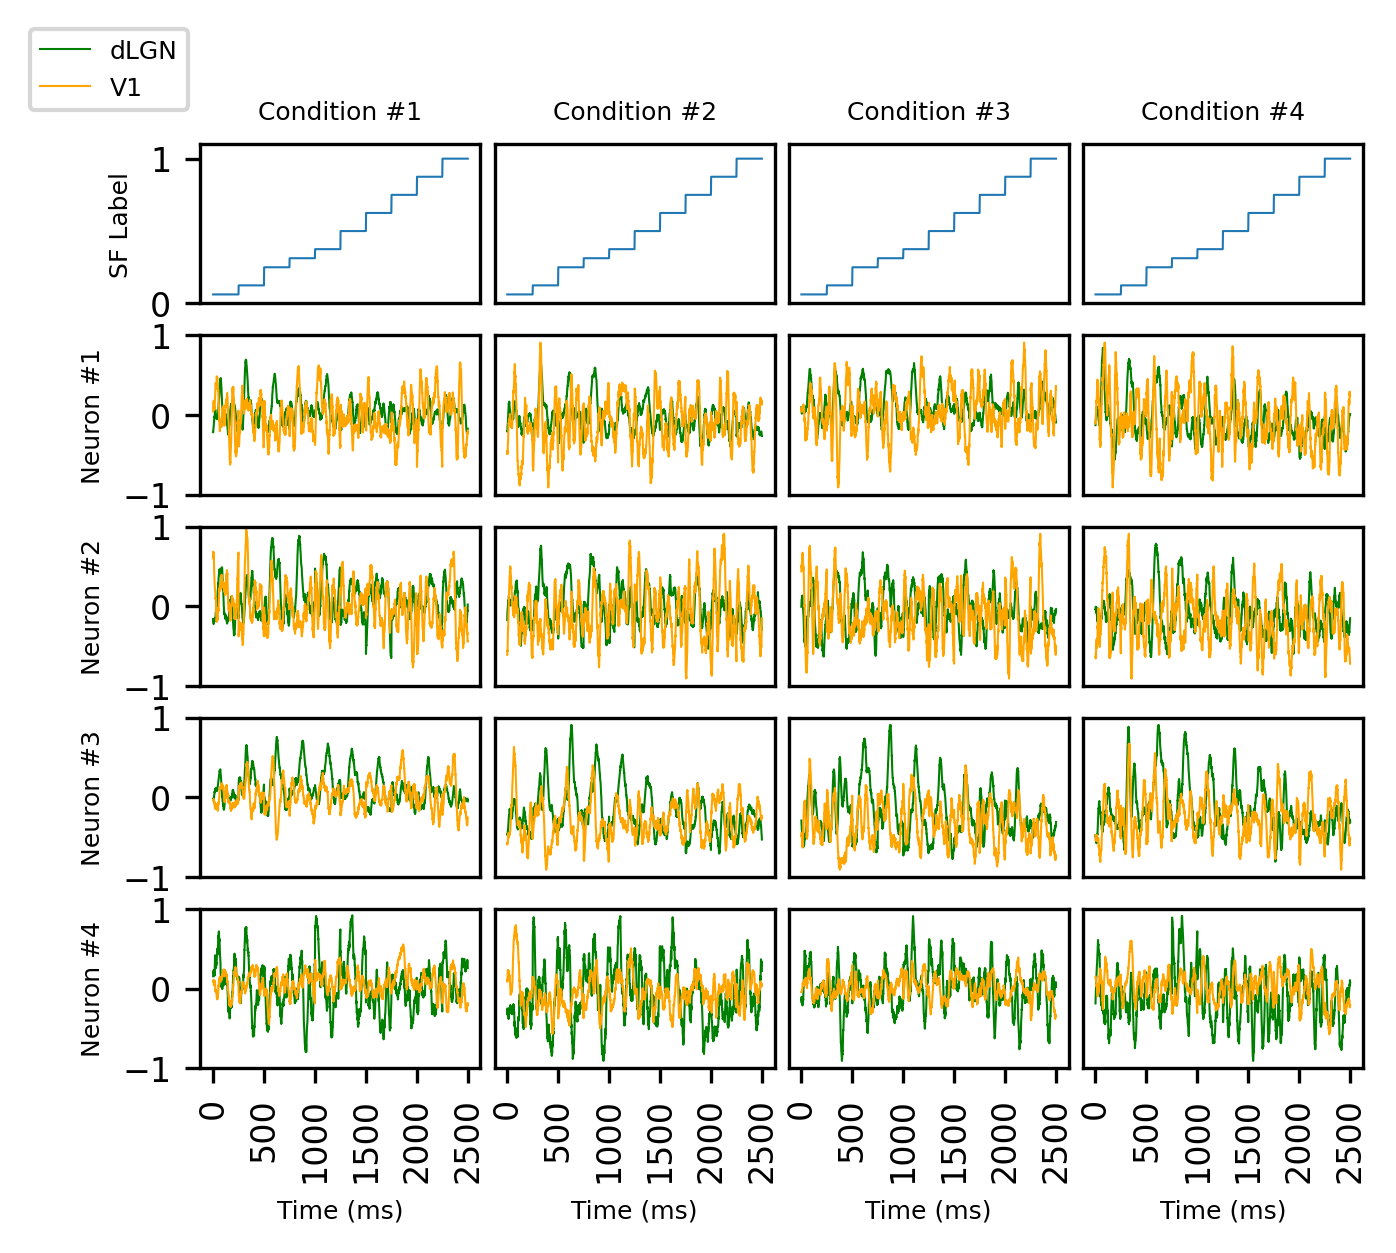

In [9]:
## Show responses at the first 4 (out of 16) orientation/phase conditions from the first 4 neurons

fig, ax = plt.subplots(5,4, figsize = (5,4))

index_map = {} 
start = 0
stop = 2500
for i in range(4):
    index_map[i] = (start, stop)
    start+=2500
    stop+=2500
    
for row in range(0,5):
    for col in range(4):
        ax[row,col].tick_params(labelsize = 8)
        
        if row == 0:
            ax[row,col].plot(Y[:2500], linewidth = 0.5)
            ax[row, col].set_ylim(0,1.1)
            ax[row, col].set_title(f"Condition #{col+1}", fontsize = 6)
        elif (row > 0) and (col<1):
            xlgn = Xlgn[row,index_map[col][0]:index_map[col][1]]
            xv1 = Xv1[row,index_map[col][0]:index_map[col][1]]
            ax[row, col].plot(xlgn, linewidth = 0.5, color = 'green', label = 'dLGN')
            ax[row, col].plot(xv1, linewidth = 0.5, color = 'orange', label = 'V1')
            ax[row, col].set_ylabel(f"Neuron #{row}", fontsize = 6)
        else:
            xlgn = Xlgn[row,index_map[col][0]:index_map[col][1]]
            xv1 = Xv1[row,index_map[col][0]:index_map[col][1]]
            ax[row, col].plot(xlgn, linewidth = 0.5, color = 'green')
            ax[row, col].plot(xv1, linewidth = 0.5, color = 'orange')
        if row < 4:
            ax[row, col].set_xticks([])
        else:
            ax[row, col].set_xticks(np.arange(0,3000,500))
            ax[row, col].set_xticklabels(np.arange(0,3000,500), rotation = 90)
            ax[row, col].set_xlabel("Time (ms)", fontsize = 6)
            
        if col>0:
            ax[row, col].set_yticks([])
        elif (col == 0) and (row>0):
            ax[row, col].set_ylim(-1,1)
            
ax[0,0].set_ylabel("SF Label", fontsize = 6)
fig.subplots_adjust(wspace = 0.05)
ax[1,0].legend(fontsize = 6, bbox_to_anchor = (0,3))

## Train/test splitting

- Training will be done on 15/16 orientation/phase conditions of the data. Testing will be done on the remaining condition. Cross validation will be done by circular shifting the conditions (schematic describing this regime coming soon).
- Each orientation/phase condition is 2500 time steps long. So the training set will be the first 15*2500 timesteps and the test set will be the last 2500 timesteps.
- 250 ms stimulus triggered responses are shown for each spatial frequency (SF) condition 

In [10]:
trainXlgn = Xlgn[:,:-2500]
testXlgn = Xlgn[:,-2500:]

trainXv1 = Xv1[:,:-2500]
testXv1 = Xv1[:,-2500:]

trainY = Y[:-2500]
testY = Y[-2500:]

print(f"Shape of the dLGN training set: {trainXlgn.shape}")
print(f"Shape of the dLGN test set: {testXlgn.shape}\n")

print(f"Shape of the V1 training set: {trainXv1.shape}")
print(f"Shape of the V1 test set: {testXv1.shape}\n")

print(f"Shape of the dependent variable training set: {trainY.shape}")
print(f"Shape of the dependent variable test set: {testY.shape}")

Shape of the dLGN training set: (237, 37500)
Shape of the dLGN test set: (237, 2500)

Shape of the V1 training set: (259, 37500)
Shape of the V1 test set: (259, 2500)

Shape of the dependent variable training set: (37500,)
Shape of the dependent variable test set: (2500,)


## Shaping the data

- The input needs to be the the firing rates of the neuronal population at the current time plus the firing rates at a certain number of lags in the past.
- The shape needs to be (timesteps/samples, timelags, neurons/features)

In [11]:
from scipy.linalg import toeplitz
def design_matrix(X, lag): 
        """
        Design a data matrix with timelagged features. Adapted from:
        Adapted from: https://github.com/melizalab/comp-neurosci/blob/master/4-Receptive-Fields.ipynb
        
        The input (X) nees to have shape = (samples, features)
        """

        # T is the number of time steps, N is the number of features
        T, N = X.shape

        # initialize a list to hold the toeplitz matricies for each channel
        toeps = []

        # for each channel
        for n in range(N):
            
            pad = np.zeros(lag+1) # make a padding array 

            # create the toeplitz matrix for the stim at channel i
            x = toeplitz(X[:,n], pad)[:,::-1]

            # append to the holding list
            toeps.append(x)

            del x
        
        # the transpose formats the matrix as (samples, timelags, features)
        Xlagged = np.array(toeps).transpose(1,2,0)
        
        return Xlagged

In [12]:
# Use the current time step and look back 30 timesteps into the past.

trainXlgn = design_matrix(trainXlgn.T, 30).astype(np.float16)
testXlgn = design_matrix(testXlgn.T, 30).astype(np.float16)

trainXv1 = design_matrix(trainXv1.T, 30).astype(np.float16)
testXv1 = design_matrix(testXv1.T, 30).astype(np.float16)

In [13]:
print(f"Shape of the dLGN training set: {trainXlgn.shape}")
print(f"Shape of the dLGN test set: {testXlgn.shape}\n")

print(f"Shape of the V1 training set: {trainXv1.shape}")
print(f"Shape of the V1 test set: {testXv1.shape}\n")

print(f"Shape of the dependent variable training set: {trainY.shape}")
print(f"Shape of the dependent variable test set: {testY.shape}")

Shape of the dLGN training set: (37500, 31, 237)
Shape of the dLGN test set: (2500, 31, 237)

Shape of the V1 training set: (37500, 31, 259)
Shape of the V1 test set: (2500, 31, 259)

Shape of the dependent variable training set: (37500,)
Shape of the dependent variable test set: (2500,)


## Define and fit the model

We will demonstrate the model with some predefined hyperparameters. 

- Model architecture: There are two LSTM layers in the model, inspired by Kashefi & Daliri (2021). The first layer has 100 neurons to reduce the feature space into a latent space containing most of the explained variance of the data. The second layer has 10 neurons (theoretically mapping the features to the 10 SF conditions). The final layer is a simple output layer with one neuron to give the prediction. 
- Epochs: 15 is chosen to balance performance with time complexity.
- Batch size: 250 is chosen because the stimulus triggered response is 250 timesteps.
- The output of the decoder is given as a tuple with the prediction (y-hat) and the mean absolue error across orientation/phase conditions.

In [14]:
lgn_decoder_output = lstm_decoder(
    trainXlgn, trainY, 
    testXlgn, testY,
    15, 250
)

In [15]:
v1_decoder_output = lstm_decoder(
    trainXv1, trainY, 
    testXv1, testY,
    15, 250
)

Text(0.5, 1.0, 'Single prediction results')

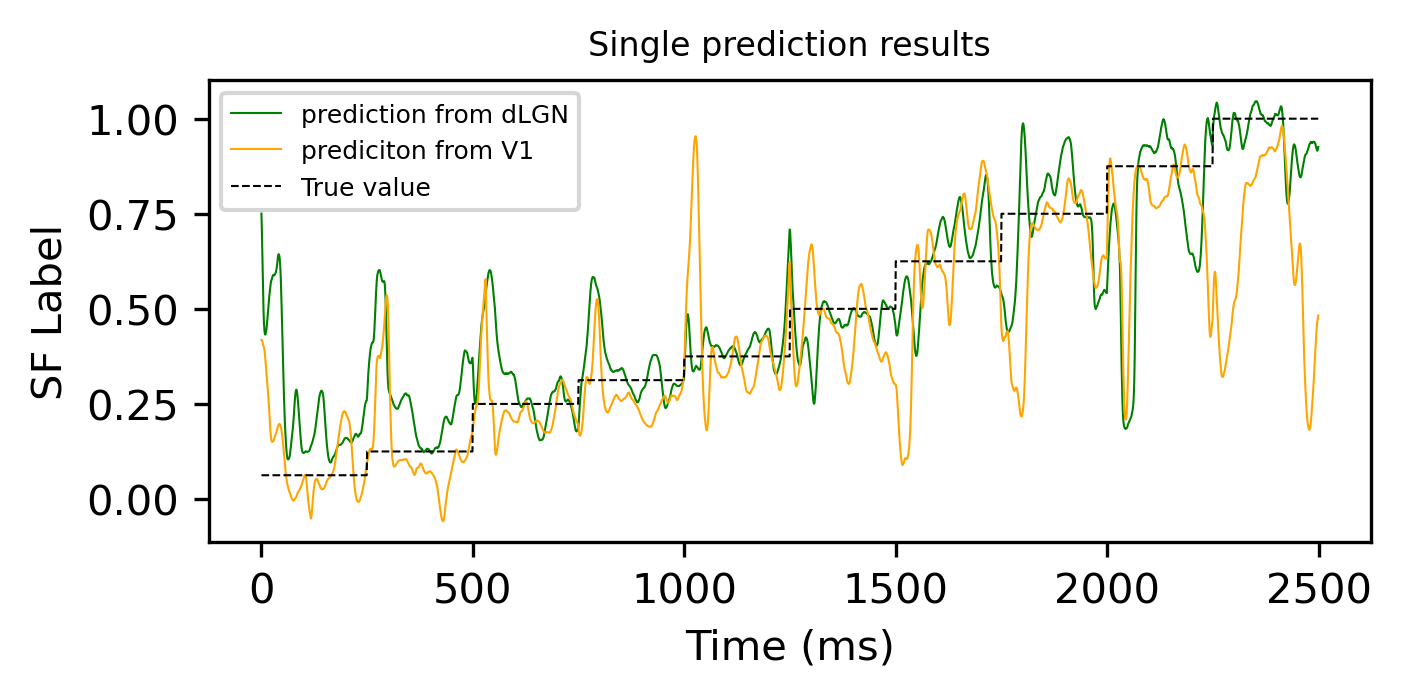

In [16]:
fig, ax = plt.subplots(figsize = (5, 2))
ax.plot(lgn_decoder_output[0], color = 'green', linewidth = 0.5, label = 'prediction from dLGN')
ax.plot(v1_decoder_output[0], color = 'orange', linewidth = 0.5, label = 'prediciton from V1')
ax.plot(testY, '--', color = 'black', linewidth = 0.5, label = 'True value')
ax.set_ylabel('SF Label')
ax.set_xlabel('Time (ms)')
ax.legend(fontsize = 6)
ax.set_title("Single prediction results", fontsize = 8)

Text(0.5, 1.0, 'Single prediction results')

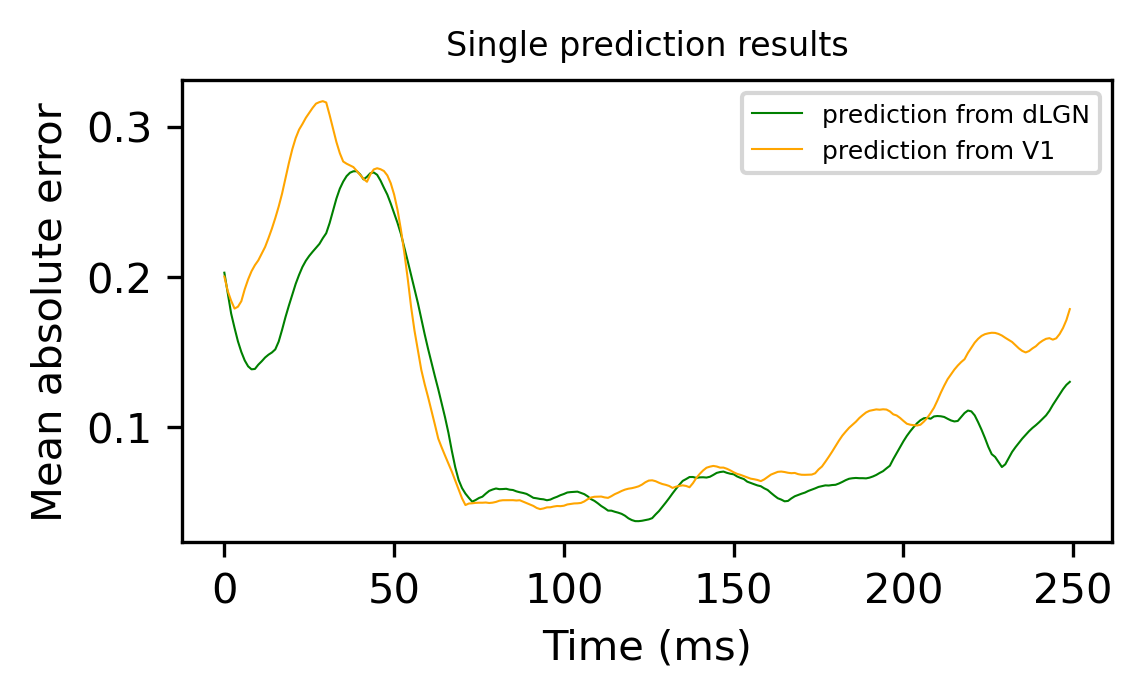

In [17]:
fig, ax = plt.subplots(figsize = (4, 2))
ax.plot(lgn_decoder_output[1], color = 'green', linewidth = 0.5, label = 'prediction from dLGN')
ax.plot(v1_decoder_output[1], color = 'orange', linewidth = 0.5, label = 'prediction from V1')
ax.set_ylabel("Mean absolute error")
ax.set_xlabel("Time (ms)")
ax.legend(fontsize = 6)
ax.set_title("Single prediction results", fontsize = 8)

## Generate the cross validation folds

In [18]:
def cv_split(X, sample_axis = 1, test_timesteps = 2500):
    
    # create the initial split
    data = {
        'train': [X[:,:-test_timesteps].astype(np.float16)],
        'test': [X[:,-test_timesteps:].astype(np.float16)]
    }
    
    total_timesteps = X.shape[sample_axis]
    n_splits = int((total_timesteps/test_timesteps)-1)
    
    for i in range(n_splits):
        X = np.roll(X, test_timesteps, axis=sample_axis)
        data['train'].append(X[:,:-test_timesteps].astype(np.float16))
        data['test'].append(X[:,-test_timesteps:].astype(np.float16))
    del X
    return data

In [19]:
# split the data at each orientation/phase condition into train/test
lgn_data = cv_split(Xlgn)

# create a design matrix for each fold
lag = 30
for key, val in lgn_data.items():
    for k, fold in enumerate(val):
        val[k] = design_matrix(fold.T, lag).astype(np.float16)
        del fold
    lgn_data[key] = val
    del val
del Xlgn

In [20]:
v1_data = cv_split(Xv1)
lag = 30
for key, val in v1_data.items():
    for k, fold in enumerate(val):
        val[k] = design_matrix(fold.T, lag).astype(np.float16)
        del fold
    v1_data[key] = val
    del val
del Xv1

## Get cross validated predictions

In [21]:
## perform cross validation on the dLGN data

yhat_lgn_folds = np.zeros((16,2500))
mae_lgn_folds = np.zeros((16,250))

for fold in range(16):
    ## define the model

    lgn_decoder_output = lstm_decoder(
        lgn_data['train'][fold], trainY, 
        lgn_data['test'][fold], testY,
        15, 250
    )

    ## Save the prediction
    yhat_lgn = lgn_decoder_output[0]
    yhat_lgn_folds[fold] = yhat_lgn.flatten()

    ## Save the mae
    mae_lgn = lgn_decoder_output[1]
    mae_lgn_folds[fold] = mae_lgn

lgn_results = {'yhat': yhat_lgn_folds, 'mae': mae_lgn_folds}
del lgn_data

In [22]:
## perform cross validation on the V1 data

yhat_v1_folds = np.zeros((16,2500))
mae_v1_folds = np.zeros((16,250))

for fold in range(16):
    ## define the model

    v1_decoder_output = lstm_decoder(
        v1_data['train'][fold], trainY, 
        v1_data['test'][fold], testY,
        15, 250
    )

    ## Save the prediction
    yhat_v1 = v1_decoder_output[0]
    yhat_v1_folds[fold] = yhat_v1.flatten()

    ## Save the mae
    mae_v1 = v1_decoder_output[1]
    mae_v1_folds[fold] = mae_v1

v1_results = {'yhat': yhat_v1_folds, 'mae': mae_v1_folds}
del v1_data

Text(0.5, 1.0, 'Cross validated prediction results')

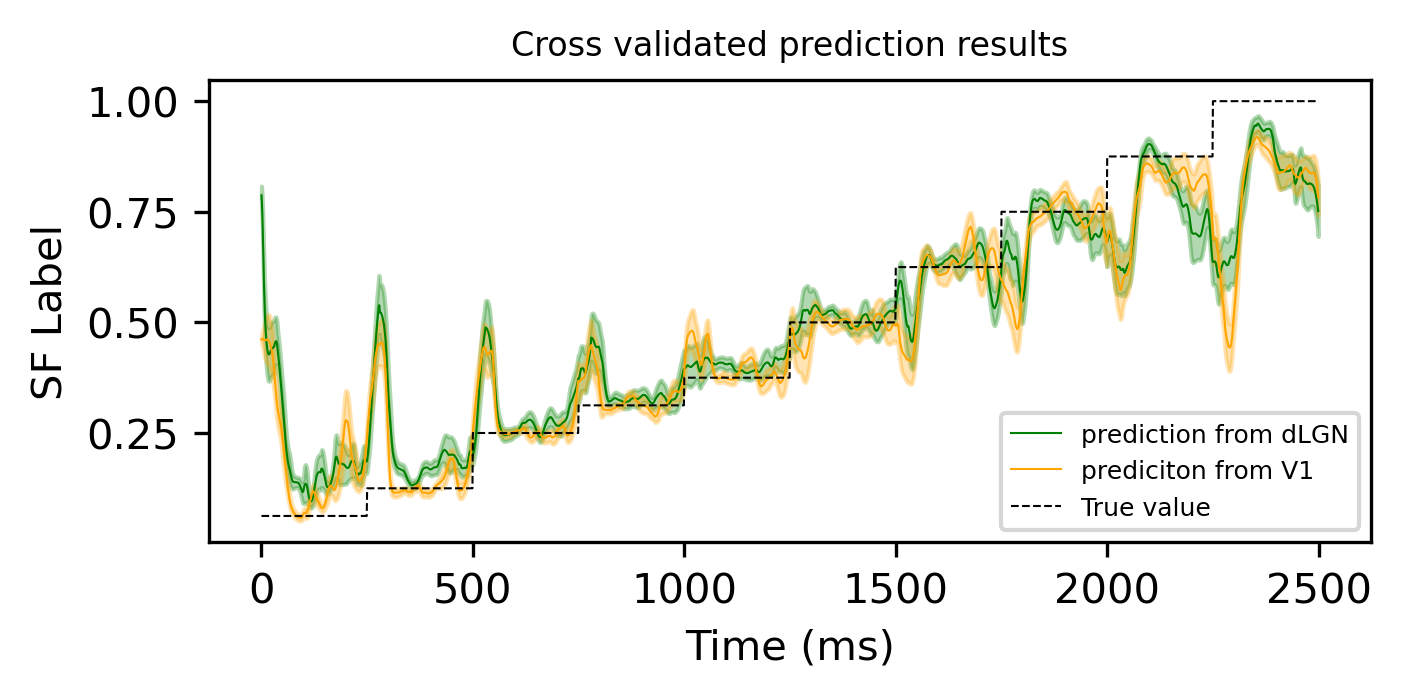

In [24]:
fig, ax = plt.subplots(figsize = (5, 2))
ax.plot(lgn_results['yhat'].mean(0), color = 'green', linewidth = 0.5, label = 'prediction from dLGN')
plt.fill_between(
    np.arange(2500),
    lgn_results['yhat'].mean(0) - lgn_results['yhat'].std(0)/np.sqrt(16),
    lgn_results['yhat'].mean(0) + lgn_results['yhat'].std(0)/np.sqrt(16),
    lgn_results['yhat'].mean(0), color = 'green', alpha = 0.3
)
ax.plot(v1_results['yhat'].mean(0), color = 'orange', linewidth = 0.5, label = 'prediciton from V1')
plt.fill_between(
    np.arange(2500),
    v1_results['yhat'].mean(0) - v1_results['yhat'].std(0)/np.sqrt(16),
    v1_results['yhat'].mean(0) + v1_results['yhat'].std(0)/np.sqrt(16),
    v1_results['yhat'].mean(0), color = 'orange', alpha = 0.3
)
ax.plot(testY, '--', color = 'black', linewidth = 0.5, label = 'True value')
ax.set_ylabel('SF Label')
ax.set_xlabel('Time (ms)')
ax.legend(fontsize = 6)
ax.set_title("Cross validated prediction results", fontsize = 8)

Text(0.5, 1.0, 'Single prediction results')

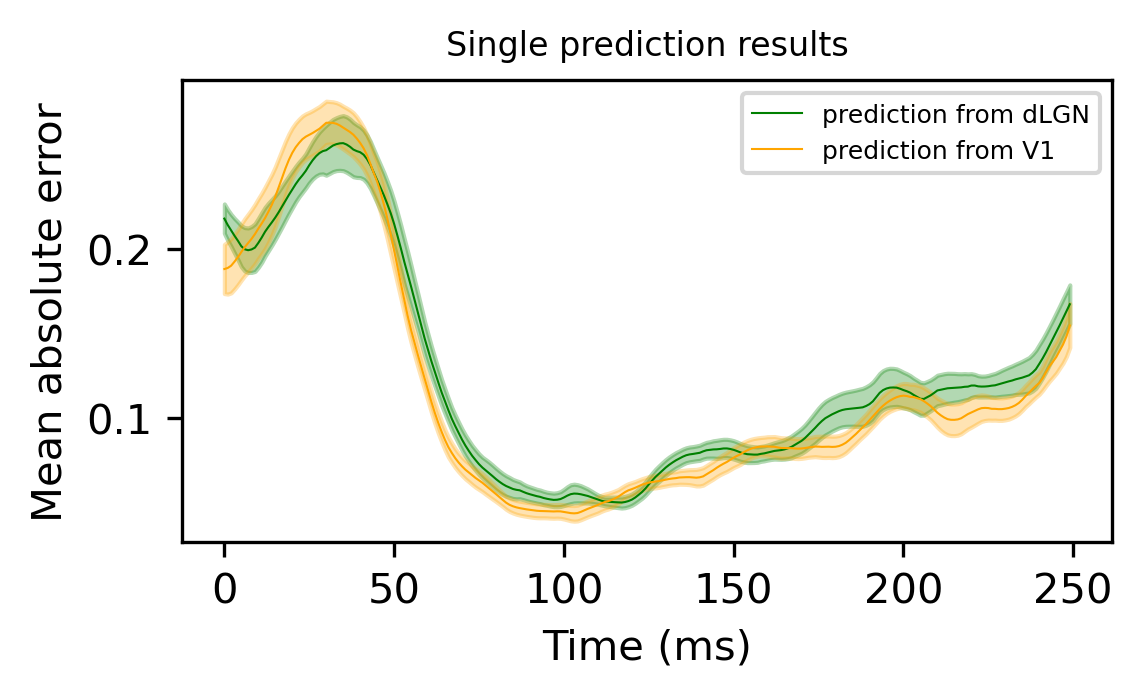

In [25]:
fig, ax = plt.subplots(figsize = (4, 2))
ax.plot(lgn_results['mae'].mean(0), color = 'green', linewidth = 0.5, label = 'prediction from dLGN')
plt.fill_between(
    np.arange(250),
    lgn_results['mae'].mean(0) - lgn_results['mae'].std(0)/np.sqrt(16),
    lgn_results['mae'].mean(0) + lgn_results['mae'].std(0)/np.sqrt(16),
    lgn_results['mae'].mean(0), color = 'green', alpha = 0.3
)
ax.plot(v1_results['mae'].mean(0), color = 'orange', linewidth = 0.5, label = 'prediction from V1')
plt.fill_between(
    np.arange(250),
    v1_results['mae'].mean(0) - v1_results['mae'].std(0)/np.sqrt(16),
    v1_results['mae'].mean(0) + v1_results['mae'].std(0)/np.sqrt(16),
    v1_results['mae'].mean(0), color = 'orange', alpha = 0.3
)
ax.set_ylabel("Mean absolute error")
ax.set_xlabel("Time (ms)")
ax.legend(fontsize = 6)
ax.set_title("Single prediction results", fontsize = 8)